In [1]:
%load_ext autoreload
%autoreload 2

# Files needed:

* Effective area: `Plenum/resources/IC86_II_effectiveArea.csv` (from data release)
* Resolution: `Plenum/resources/IC86_II_smearing.csv` (from data release)
* Background flux: `Plenum/resources/MCEq_daemonflux.pckl`

# Imports

In [2]:
import pickle
from collections import namedtuple
from copy import copy

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import fmin_l_bfgs_b

from scipy.stats import chi2, gaussian_kde, norm
from scipy.interpolate import RegularGridInterpolator

from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Settings

see `settings.py`


In [3]:
LIVETIME = 3 * 365 * 24 * 3600  # 3 years
#LIVETIME = 3186 * 24 * 3600  # new ngc paper
# LIVETIME = 10 * 360 * 24 * 3600  # 360 days of data taking per year in seconds
E_NORM = 1e5  # normalization energy of power law (E/E_NORM)^gamma
# --> 100 TeV
# Diffuse nu-mu paper now available at https://arxiv.org/abs/2111.10299
GAMMA_ASTRO = 2.37
PHI_ASTRO_FACTOR = 1.44
# we use this factor such that PHI_ASTRO_FACTOR can be of order 1
PHI_0 = 1.0e-18  # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s
PHI_ASTRO = PHI_ASTRO_FACTOR * PHI_0  # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s

# Science Paper parameters of NGC 1068
GAMMA_NGC = 3.2
PHI_NGC = 5e-14  # @ 1 TeV / GeV cm² s
E0_NGC = 1e3
# gaussian sigma values
sigma5 = 1 - norm.cdf(5)
sigma3 = 1 - norm.cdf(3)
sigma2 = 1 - norm.cdf(2)
sigma1 = 1 - norm.cdf(1)

# important object coordinates
sgr_a = SkyCoord(0, 0, unit="rad", frame="galactic")
txs0506 = SkyCoord(77.36, 5.69, unit="deg", frame="icrs")
ngc1068 = SkyCoord(40.67, -0.01, unit="deg", frame="icrs")
# livetime in seconds and days
print(LIVETIME, LIVETIME / 24 / 3600)
# Normalization energy of power law (E/E_NORM)^GAMMA_ASTRO
print(E_NORM)  # in GeV
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299

print(GAMMA_ASTRO)  # spectral index
print(PHI_ASTRO)  # neutrinos * (E/E_NORM)^GAMMA_ASTRO / GeV / cm^2 / s / sr

# your paths:
BASEPATH = ""
LOCALPATH = ""
print(BASEPATH)
print(LOCALPATH)


94608000 1095.0
100000.0
2.37
1.44e-18




# Standalone functions

In [4]:
E_MIN = 2  # 100 GeV
E_MAX = 9  # 10**9 GeV = 1 EeV

# The comments mention the files where the actual plenum-tool function can be found.


def read_effective_area():  # tools.py
    column_names = [
        "logE_nu_min",
        "logE_nu_max",
        "Dec_nu_min",
        "Dec_nu_max",
        "A_eff",
    ]

    public_data_aeff = pd.read_table(
        "../../resources/IC86_II_effectiveArea.csv",
        sep="\s+",
        skiprows=1,
        names=column_names,
    )
    return public_data_aeff


def read_smearing_matrix():  # tools.py
    """Read the public-data smearing matrix into a data frame."""

    column_names = [
        "logE_nu_min",
        "logE_nu_max",
        "Dec_nu_min",
        "Dec_nu_max",
        "logE_reco_min",
        "logE_reco_max",
        "PSF_min",
        "PSF_max",
        "AngErr_min",
        "AngErr_max",
        "Fractional_Counts",
    ]

    public_data_df = pd.read_table(
        "../../resources/IC86_II_smearing.csv",
        sep="\s+",
        skiprows=1,
        names=column_names,
    )
    return public_data_df


def get_mids(bins, ext=False):  # tools.py
    """Calculate the bin mids from an array of bin edges."""
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext == False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res


def calc_baseline_energy_res(
    logE_bins=None, logE_reco_bins=None
):  # adapted from resolution.py

    filename = f"../../resources/energy_smearing_2D.pckl"
    print("calculating grids for energy resolution...")

    # load smearing matrix
    public_data_df = read_smearing_matrix()

    log_sm_emids = (public_data_df["logE_nu_min"] + public_data_df["logE_nu_max"]) / 2.0
    log_sm_ereco_mids = (
        public_data_df["logE_reco_min"] + public_data_df["logE_reco_max"]
    ) / 2.0
    fractional_event_counts = public_data_df["Fractional_Counts"]
    dec_sm_min, dec_sm_max = (
        public_data_df["Dec_nu_min"],
        public_data_df["Dec_nu_max"],
    )
    dec_sm_mids = (dec_sm_min + dec_sm_max) / 2.0
    if logE_bins is None:
        logE_bins = np.unique([public_data_df.logE_nu_min, public_data_df.logE_nu_max])
    if logE_reco_bins is None:
        logE_reco_bins = np.arange(
            np.min(logE_bins),
            np.max(logE_bins),
            step=0.2,
        )
    logE_mids = get_mids(logE_bins)
    logE_reco_mids = get_mids(logE_reco_bins)
    ee, rr = np.meshgrid(logE_mids, logE_reco_mids)

    # down-going (=South): -90 -> -10 deg
    # horizontal: -10 -> 10 deg
    # up-going (=North): 10 -> 90 deg
    all_grids = {}

    # loop over declination bins
    for dd in np.unique(dec_sm_mids):
        dec_mask = dec_sm_mids == dd
        # energy resolution per declination bin
        e_ereco_kdes = gaussian_kde(
            (log_sm_emids[dec_mask], log_sm_ereco_mids[dec_mask]),
            weights=fractional_event_counts[dec_mask],
        )
        all_grids[f"dec-{dd}"] = e_ereco_kdes([ee.flatten(), rr.flatten()]).reshape(
            len(logE_reco_mids), len(logE_mids)
        )
        all_grids[f"dec-{dd}"] /= np.sum(all_grids[f"dec-{dd}"], axis=0)

    with open(filename, "wb") as f:
        pickle.dump((all_grids, logE_bins, logE_reco_bins), f)


def calc_aeff_factor(
    aeff, e_width, livetime, sindec_width, ra_width
):  # aeff_calculations.py
    """
    Neutrino events N = T_live * int_dSin(theta) (int_dE (int_dphi ( A_eff * dPhi/dE)))
    A_eff_factor = dSin(theta) * dE * int_dphi (= 2pi) * A_eff * T_live (<-- this is calculated here)
    => N = Sum(A_eff_factor * dPhi/dE) (see def astro_flux)
    """
    ra_width = np.atleast_1d(ra_width)
    aeff_factor = (
        aeff * sindec_width[:, np.newaxis] * e_width * np.sum(ra_width) * livetime
    )
    return aeff_factor


def power_law(energy, e_scale, gamma, phi0):  # fluxes.py
    """Generic form of power-law spectrum: (energy / e_scale) ** (-gamma) * phi0
    energy: array
        energy values to evaluate the power-law spectrum
    e_scale: float
        normalization of the energy scale
    gamma: float (positive)
        spectral index, will be multiplied by -1
    phi0: float
        flux normalization at the given energy scale

    """
    return (energy / e_scale) ** (-gamma) * phi0


def astro_flux(
    aeff_factor,
    emids,
    energy_resolution,
    phi_scaling,
    flux_shape,
):  # fluxes.py
    """N = Sum(A_eff_factor * dPhi/dE) (see def calc_aeff_factor)"""
    flux_base = aeff_factor * power_law(
        emids, flux_shape.E0, flux_shape.gamma, flux_shape.norm * phi_scaling
    )
    return energy_smearing(energy_resolution, flux_base)


def atmo_background(aeff_factor, bckg_vals, energy_resolution):  # fluxes.py
    """Calculate the number of neutrinos of atmospheric background flux
    as a function neutrino energy or reconstructed energy.

    If aeff_factor is 2D, eg. in sin(dec) and log(E_true),
    the result will also be 2D, in sin(dec) and log(E_reco) then.

    Parameters:
    aeff_factor: array
        effective area multiplied with binning and livetime
    bckg_vals: atmospheric background flux binned the same way as aeff_factor
    energy_resolution: Optional
        If the energy resolution matrix is given,
        calculate the background events for reconstructed energy;
        If None, return background events for true neutrino energy

    """
    return energy_smearing(energy_resolution, aeff_factor * bckg_vals)


def energy_smearing(ematrix, ev):  # resolution.py
    """Matrix multiplication with the energy resolution
    to translate an event histogram from E_true to E_reco.

    Expected formats: (need to double check ....)
    ematrix: logE_reco x logE
    ev: any x logE
    """
    if ematrix is None:
        return ev  # do nothing
    else:
        return (ematrix @ ev.T).T  # returns any x logE_reco


def poisson_llh(mu_i, k_i):  # likelihood.py
    """Calculate the -2 log(Poisson LLH).

    L(data k | model mu)  = prod_{i,j} mu_ij ** k_ij / k_ij! * exp(-mu_ij)

    For numerical stability, we directly evaluate the log of the poisson probability
    (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function).

    Since we are using Asimov data that can have floating point values, we need to implement the function
    instead of using scipy.stats.poisson.logpmf. (It fails for floats in k_i!!)
    For numerical stability, we directly evaluate (see https://en.wikipedia.org/wiki/Stirling%27s_approximation for approximation of the faculty function)
    $-2 \log (\mathcal{L}) = -2\cdot (k_i \cdot \log(\mu_i)
                - \mu_i
                - 0.5 \cdot \log(2 \pi \cdot k_i)
                + k_i
                - k_i \cdot \log(k_i))$

    -2 log (L) = -2 [k_i log(mu_i) - mu_i - 0.5 log(2 pi k_i) + k_i - k_i log(k_i)]

    We treat some special cases that may cause problems in log:

    * mu -> 0, k>0     --> P -> 0
    * k -> 0, mu>0     --> P -> exp(-mu)
    * k -> 0, mu -> 0  --> P -> 1

    """
    log_LLH = np.zeros_like(mu_i)
    # k == 0, mu > 0:
    _mask = (k_i == 0) & (mu_i > 0)
    log_LLH[_mask] = -mu_i[_mask]
    # k == 0, mu == 0:
    _mask = (k_i == 0) & (mu_i == 0)
    log_LLH[_mask] = 0
    # k > 0, mu==0: should not happen! we'll assign a very negative value
    _mask = (k_i > 0) & (mu_i == 0)
    log_LLH[_mask] = -1e16
    # k > 0, mu > 0
    _mask = (k_i > 0) & (mu_i > 0)
    log_LLH[_mask] = (
        k_i[_mask] * np.log(mu_i[_mask])
        - mu_i[_mask]
        - 0.5 * np.log(2 * np.pi * k_i[_mask])
        + k_i[_mask]
        - k_i[_mask] * np.log(k_i[_mask])
    )

    return -2 * np.sum(log_LLH)

# Compute Files

## effective area

35 energy bins
50 declination bins
log_10(energy) bin edges, min and max 36 2.0 9.0
declination bin edges, min and max 51 -1.0 1.0


(2.0, 9.0)

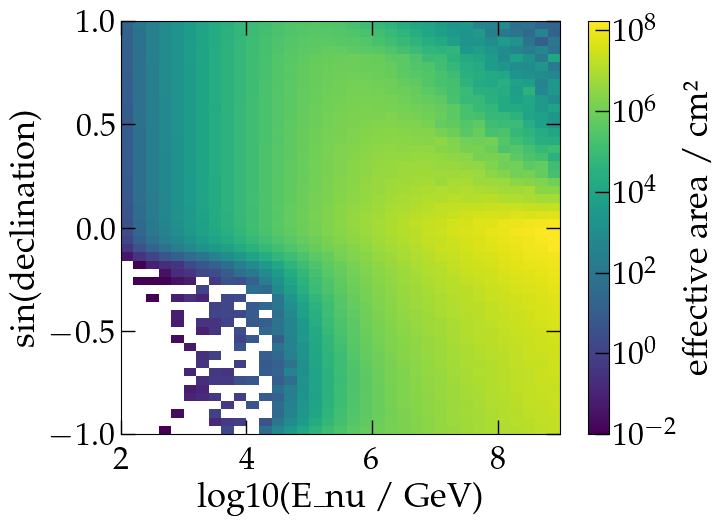

In [5]:
public_data_aeff = read_effective_area()
# log10(E_nu/GeV)_min log10(E_nu/GeV)_max
# Dec_nu_min[deg] Dec_nu_max[deg]
# A_Eff[cm^2]

# the file contains all bin edges and the effective area contained in this bin
# in the following, we use the binning given with the effective area to be consistent

sindec_bins = np.unique(
    np.sin(np.deg2rad([public_data_aeff.Dec_nu_min, public_data_aeff.Dec_nu_max]))
)
sindec_bins = np.round(sindec_bins, 2)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

logE_bins = np.unique([public_data_aeff.logE_nu_min, public_data_aeff.logE_nu_max])


# re-shape into 2D array with (A(E) x A(delta))
# and switch the eff area ordering
aeff_2d = (
    public_data_aeff["A_eff"].values.reshape(len(sindec_mids), len(logE_bins)-1).T
)

logE_mids = get_mids(logE_bins)
# cut all arrays at E=10⁹GeV
logE_bins = logE_bins[logE_bins<=9]
# for this demo, we only look at IceCube's effective area
aeff_2d = aeff_2d[logE_mids<=9]
logE_mids = logE_mids[logE_mids<=9]

# derivatives
ebins = np.power(10, logE_bins)
emids = np.power(10, get_mids(logE_bins))
ewidth = np.diff(ebins)
# Right ascension
ra_width = 2 * np.pi

print(len(emids), "energy bins")
print(len(sindec_mids), "declination bins")
print("log_10(energy) bin edges, min and max", len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print("declination bin edges, min and max", len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))

# plot the effective area (only up-going events)
plt.figure(figsize=(7, 5))
plt.pcolormesh(logE_bins, sindec_bins, aeff_2d.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 9)

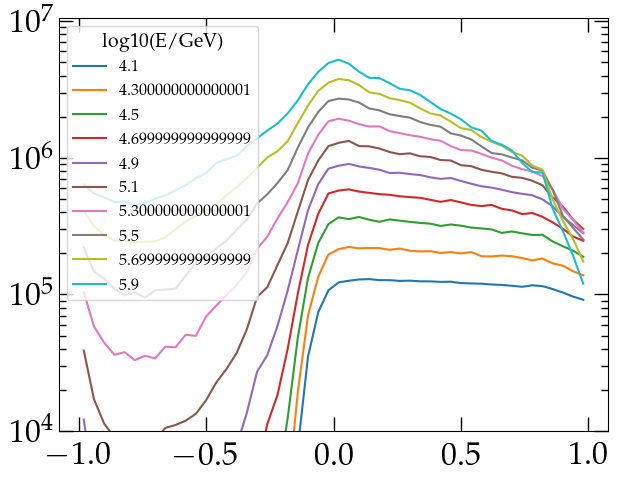

In [6]:
# 1D slices
plt.figure(figsize=(7,5))
_ = plt.plot(sindec_mids, aeff_2d[10:20].T, label=logE_mids[10:20])
# plt.xlim(-1, 0.1)
plt.yscale("log")
plt.ylim(1E4, None)
plt.legend(fontsize="small", title="log10(E/GeV)")

## energy resolution


In [7]:
calc_baseline_energy_res(logE_bins=logE_bins)

filename = "../../resources/energy_smearing_2D.pckl"
with open(filename, "rb") as f:
    energy_all_grids, _, logE_reco_bins = pickle.load(f)
logE_reco_mids = get_mids(logE_reco_bins)

calculating grids for energy resolution...


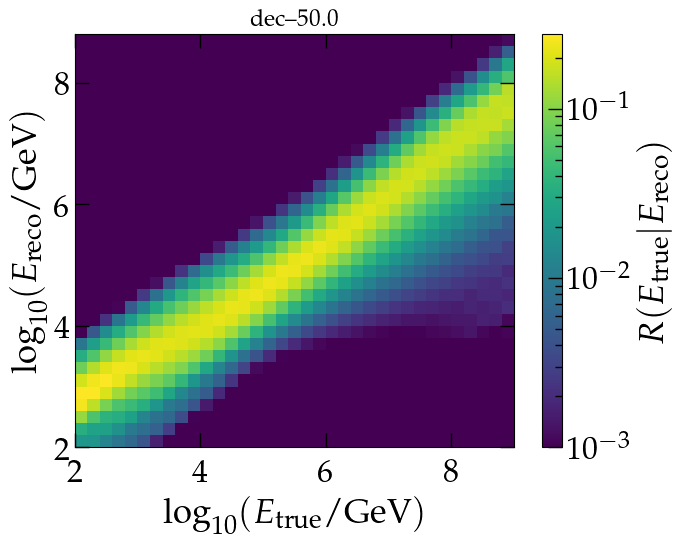

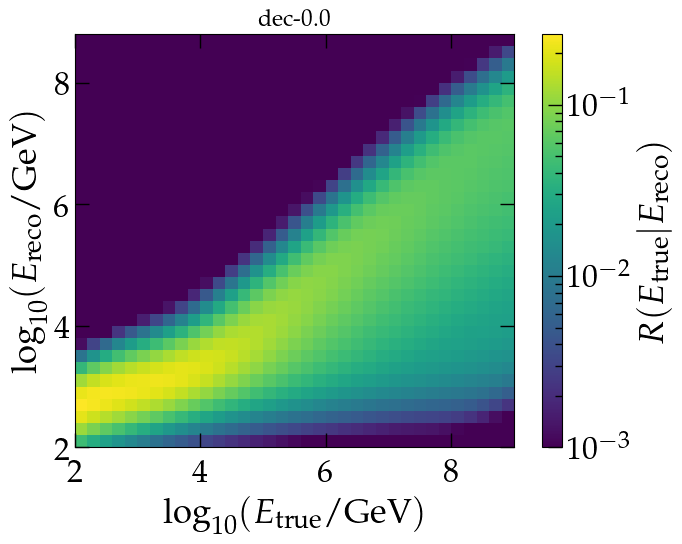

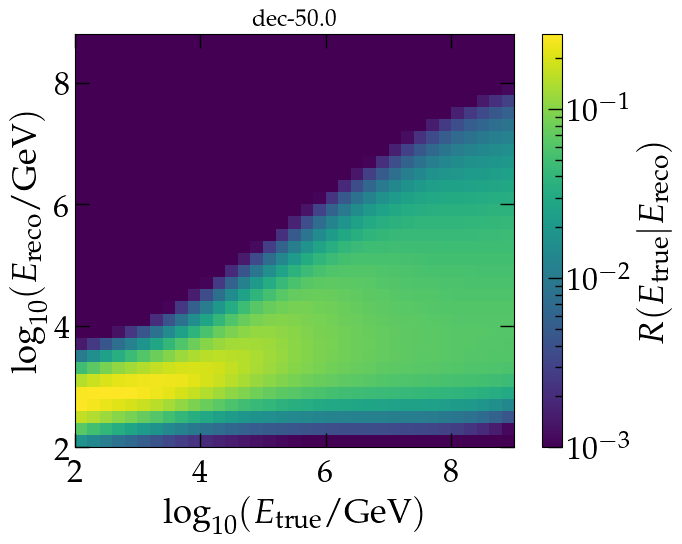

In [8]:
for dec in energy_all_grids.keys():
    plt.figure(figsize=(7, 5))
    plt.pcolormesh(logE_bins, logE_reco_bins, energy_all_grids[dec], norm=LogNorm(vmin=1E-3))
    cb = plt.colorbar()
    cb.set_label(r"$R(E_{\rm true} | E_{\rm reco})$")
    plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
    plt.ylabel(r"$\log_{10}(E_{\rm reco} / {\rm GeV})$")
    plt.title(dec)

## background flux

(2.0, 9.0)

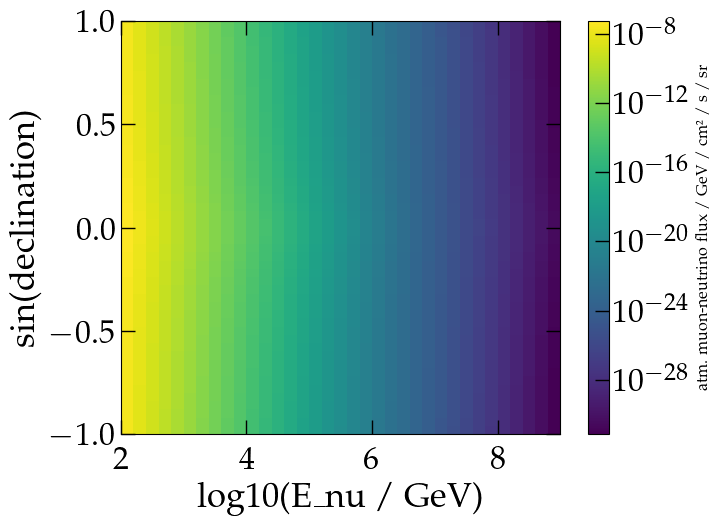

In [9]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_daemonflux.ipynb')
with open("../../resources/MCEq_daemonflux.pckl", "rb") as f:
    (e_grid, zen), bckg_flux = pickle.load(f)

# set up the interpolation function for re-binning
sindec_mids_bg = -np.cos(np.deg2rad(zen))
bckg_rgi = RegularGridInterpolator(
    (e_grid, sindec_mids_bg),
    np.log(bckg_flux ),
    method="linear",
)

# baseline evaluation of the interpolation
# such that it matches the effective area binning
ss, em = np.meshgrid(sindec_mids, emids)
# bckg flux as a function of log10(true energy/GeV) and sin(dec)
bckg_flux_vals = np.exp(bckg_rgi((em, ss))).T # / GeV / cm² / s / sr



# visualization of bckg flux
plt.figure(figsize=(7, 5))
plt.pcolormesh(logE_bins, sindec_bins, bckg_flux_vals, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr", fontsize="small")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 9)




# Source flux definition
$N_{\nu} = T_{\rm live} \cdot \int_{\Delta \Omega} d \Omega \, d E \, \int_{E_{\min}}^{E_{\max}} dE \, A_{\rm eff} \left( E, \sin(\delta)\right) \cdot \frac{d \Phi}{d E} $

Approximate the integral with a finite-binning approach:

aeff_factor =
$ 2\pi \cdot T_{live} \cdot \Delta \sin (\delta) \, \Delta E \cdot A_{\rm eff} \left( E, \sin(\delta)\right) $

See also the helper functions above (`calc_aeff_factor` and `astro_flux`) .

($2\pi = \int_0^{2\pi} d\phi$; $d \Omega = d \phi \cdot d \sin(\delta)$)

In [10]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
# the simple power-law flux has 3 shape parameters (norm, gamma, E0) and a name ("powerlaw")
diffuse_flux = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")


# Config

In [11]:
# generic diffuse flux config
diffuse_config = dict(
    sindec_width=sindec_width,
    ra_width=ra_width,
    livetime=LIVETIME,
    e_width=ewidth,
)

Fit parameters for analysis:
* Global normalization of the atmospheric neutrino flux (background), $N_B$
* Global normalization of the astrophysical neutrino flux (signal), $N_S$
* Spectral index, GAMMA_ASTRO, of the astrophysical neutrino flux (signal), $\gamma$

# Calculate number of expected neutrino events

In [12]:
baseline_eres = energy_all_grids["dec-0.0"]

In [13]:
# this factor combines all factors of the effective area and bin width, times lifetime (see above)
aeff_factor = calc_aeff_factor(aeff_2d.T, **diffuse_config)


# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_flux_vals, baseline_eres)
k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))
print("S+B", np.sum(k_i))


Asimov data sum:
Background: 237878.17239172332
Signal: 976.9253082989891
S+B 238855.09770002234


# Diffuse Analysis demo

Significance test Background vs. Background + Signal

$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma \})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know


See also `likelihood.py`

In [14]:
def diffuse_llh_2d(
    x,
    mu_b_base,
    aeff_factor_s,
    k_i,
    baseline_eres,
    e_0=E_NORM,
):
    """
    Define the Log-Likelihood function depending
    on the model parameters (=fit parameters)

    Fit parameters:
    ---------------
    (= x) for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    Other parameters:
    -----------------
    mu_b_base: baseline background
    aeff_factor_s: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy
    """

    # the background model has one free parameter, the normalization (x[0])
    mu_b = mu_b_base * x[0]

    # the signal model has two free parameters:
    # the normalization x[1] and the spectral index gamma x[2]
    tmp_diff_flux = PL_flux(
        PHI_ASTRO, x[2], e_0, "powerlaw"
    )  # here we generate a flux tuple with the current parameters of the model

    mu_s = astro_flux(
        aeff_factor=aeff_factor_s,
        emids=emids,
        energy_resolution=baseline_eres,
        phi_scaling=x[1],
        flux_shape=tmp_diff_flux,
    )
    return poisson_llh(mu_b + mu_s, k_i)

The significance of the hypothesis test is evaluated using the test statistic

$TS = -2 \log ( H_0(\mu = {\rm best fit}) / H_1(\mu = {\rm best fit}) )$

where the best-fit parameters are obtained with an optimization function `fmin_l_bfgs_b`.


The data (k) is modeled as 'Asimov data', the TS calculation fulfills the requirements of Wilks' theorem, and thus we know that the underlying TS distribution
follows a $\chi ^2$ distribution, here with 2 degrees of freedom.

The p-value of the Asimov data set represents the expected significance of an analysis with real data if it has the same model parameters. It's the integral of the $\chi ^2$ distribution from TS to infinity (`chi.sf(TS)`). The p-value in terms of Gaussian standard deviations can be calculated via the inverse survival function of the normal distribution (`norm.isf(pvalue)`).

## Significance
of diffuse astrophysical neutrino flux vs. atmospheric background

In [15]:
# first, we calculate the Asimov toy data (k)
aeff_factor = calc_aeff_factor(aeff_2d.T, **diffuse_config)

# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_flux_vals, baseline_eres)
k_s = astro_flux(
    aeff_factor,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=diffuse_flux,
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))
print("S+B", np.sum(k_i))

# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: diffuse_llh_2d(
    (x[0], 0, 2), k_b, aeff_factor, k_i, baseline_eres=baseline_eres
)
# background + signal, 3 free parameters
global_llh = lambda x: diffuse_llh_2d(
    x, k_b, aeff_factor, k_i, baseline_eres=baseline_eres
)
# ... and fit both hypotheses!
# background first
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Bckg-only normalization:", out_bckg[0])
# .. then signal+background
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

## Note: out_bckg/comp[1] contains the value of the
# LLH function with the optimized model parameters
# out_bckg[1] - out_comp[1] == -2log(L(H_0) / L(H_1)) = TS (see above)

# calculate p-value and significance with Wilks' theorem and 2 d.o.f
pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
# ... we do quite well without nuisance parameters
# and without accounting for systematic uncertainties ...

Asimov data sum:
Background: 237878.17239172332
Signal: 976.9253082989891
S+B 238855.09770002234
Bckg-only normalization: [1.00410683]
Signal fit parameters: [0.99999976 1.00003729 2.37000933]
P-VALUE: 4.785615029826583e-10 SIGNIFICANCE: 6.116401000170374


## Discovery potential

In [16]:
def get_scaler(x, thresh, key_x="log10(p)", key_y="scaler"):
    """Powerlaw interpolation wrapper using a pandas.DataFrame input.
    It takes x as the DataFrame, key_x/key_y as x and y coordinates to evaluate the DF.
    Next, log10 of x and y is calculated such that a linear 'ax + b' polynomial fit can be applied.
    The polynomial is then evaluated at -log10(thresh), then translated back to the original form (10**...).

    Originally, this was used to calculate the threshold for discovery by interpolation.
    That's why it looks this complicated.
    """
    # only use finite values
    mask = np.isfinite(x[key_x]) & (x[key_x] > 0)
    if np.sum(~mask) > 10:
        raise ValueError(f"Too many non-finite values: {x[key_x]}")

    return np.power(
        10,
        np.poly1d(
            np.polyfit(np.log10(x.loc[mask, key_x]), np.log10(x.loc[mask, key_y]), 1)
        )(np.log10(-np.log10(thresh))),
    )


def scaling_estimation(
    df, current_thresholds, scaler, nmax=20, min_steps=1, stop_here=0.1, stepper=1.5
):
    """Estimate the best flux scaling factor to reach the current
    p-value threshold based on interpolating the recent tests with
    different scaling factors"""

    # First, check that the last pval we put into the df is reasonable
    # if it's nan, the scaling factor was too large
    if np.isnan(df.iloc[-1]["log10(p)"]) or (df.iloc[-1]["pval"] > 0.99):
        return scaler * stepper * 0.9
    # if it's infinite, the scaling factor was too small
    if not np.isfinite(df.iloc[-1]["log10(p)"]):
        return scaler / stepper

    # start with sampling min_steps values to estimate the scaling factor
    if len(df) <= min_steps:
        scaler_new = scaler / stepper
        return scaler_new

    # check if we already sampled close enough to the threshold
    if abs(df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0])) < stop_here:
        # when we found one pval close to the threshold,
        # pick the next threshold
        _ = current_thresholds.pop(0)
        if len(current_thresholds) == 0:
            return -1

    # do the interpolation
    # pick the first threshold from the list
    scaler_new = get_scaler(df, current_thresholds[0])

    if scaler_new <= 0 or np.isnan(scaler_new):
        # in case something went wrong (this shouldn't happen, though)
        # some random value to get started again
        print()
        raise ValueError(f"scaling went wrong: scaling value = {scaler_new}")

    # break the optimization loop once we reached nmax
    if len(df) == nmax:
        print(
            "Optimization failed within the set maximum of steps! Diff is:",
            df.iloc[-1]["log10(p)"] + np.log10(current_thresholds[0]),
            "thresh is:",
            current_thresholds[0],
        )
        _ = current_thresholds.pop(0)
    return scaler_new

In [17]:
# first, we calculate the Asimov toy data (k)

thresholds = [sigma5]
gamma_vals = np.round(np.arange(1.6, 3.3, step=0.2), 1)
aeff_factor = calc_aeff_factor(aeff_2d.T, **diffuse_config)

# asimov data
# in reconstructed energy
k_b = atmo_background(aeff_factor, bckg_flux_vals, baseline_eres)
tmp = []

for gamma in gamma_vals:
    tmp_diffuse_flux = PL_flux(PHI_ASTRO, gamma, E_NORM, "powerlaw")
    k_s = astro_flux(
        aeff_factor,
        emids,
        energy_resolution=baseline_eres,
        phi_scaling=1,
        flux_shape=tmp_diffuse_flux,
    )
    k_i = k_s + k_b

    # calculate a first estimate for the flux scaling
    if gamma <= 2.3:
        _lowecut = 15
    else:
        _lowecut = 0
    scaler = 4 / (
        np.sum(np.sum(k_s[:, _lowecut:])) / np.sqrt(np.sum(k_b[:, _lowecut:]))
    )
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:
        # scale the signal and the full data by the scaling factor
        current_k_s = scaler * k_s
        current_k = current_k_s + k_b

        # define the fitting functions with all parameters
        # background only, 1 free parameter
        local_llh = lambda x: diffuse_llh_2d(
            (x[0], 0, 2), k_b, aeff_factor, current_k, baseline_eres=baseline_eres
        )
        # background + signal, 3 free parameters
        global_llh = lambda x: diffuse_llh_2d(
            x, k_b, aeff_factor, current_k, baseline_eres=baseline_eres
        )
        # ... and fit both hypotheses!
        # background first
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            bounds=[
                (1e-3, 1e1),
            ],
            approx_grad=True,
        )
        # .. then signal+background
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3),
            bounds=[(1e-2, 10), (1e-2, 10), (1, 5)],
            approx_grad=True,
        )

        ## Note: out_bckg/comp[1] contains the value of the
        # LLH function with the optimized model parameters
        # out_bckg[1] - out_comp[1] == -2log(L(H_0) / L(H_1)) = TS (see above)

        # calculate p-value and significance with Wilks' theorem and 2 d.o.f
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = norm.isf(pval)
        tmp_dct = {
            "scaler": scaler,
            "gamma": gamma,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(current_k_s) / np.sqrt(np.sum(k_b)),  # signal over sqrt(BG)
            "n_sig": np.sum(current_k_s),
            "pval": pval,
            "log10(p)": -np.log10(pval),
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = tmp_df.gamma == gamma
        scaler = scaling_estimation(
            tmp_df[mask],
            current_thresholds,
            scaler,
            stop_here=0.1,
            stepper=1.5,
            min_steps=1,
        )

        if scaler == -1:
            break

df = pd.DataFrame(tmp)

plotting

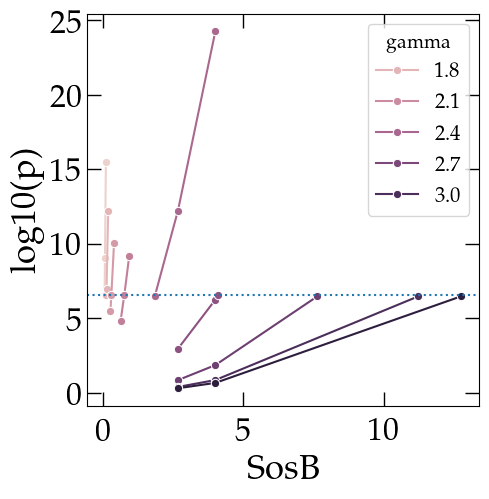

In [20]:
ax = sns.lineplot(data=df, y="log10(p)", x="SosB", marker="o", hue="gamma")
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")

In [22]:
# this function returns the interpolation which yields the 5-sigma discovery flux
# example:
get_scaler(
    df.loc[df.gamma==2.4], sigma5, key_x="log10(p)", key_y="scaler"
) * tmp_diffuse_flux.norm

1.2339461805416464e-18

In [40]:
# group by gamma and get the right scaler for 5-sigma flux
flux = pd.DataFrame(
    df.groupby(["gamma"]).apply(
        lambda x: get_scaler(x, sigma5, key_x="log10(p)", key_y="scaler"),
        include_groups=False,
    )
    * tmp_diffuse_flux.norm,
    columns=["Phi_0 at 100 TeV"],
).reset_index()

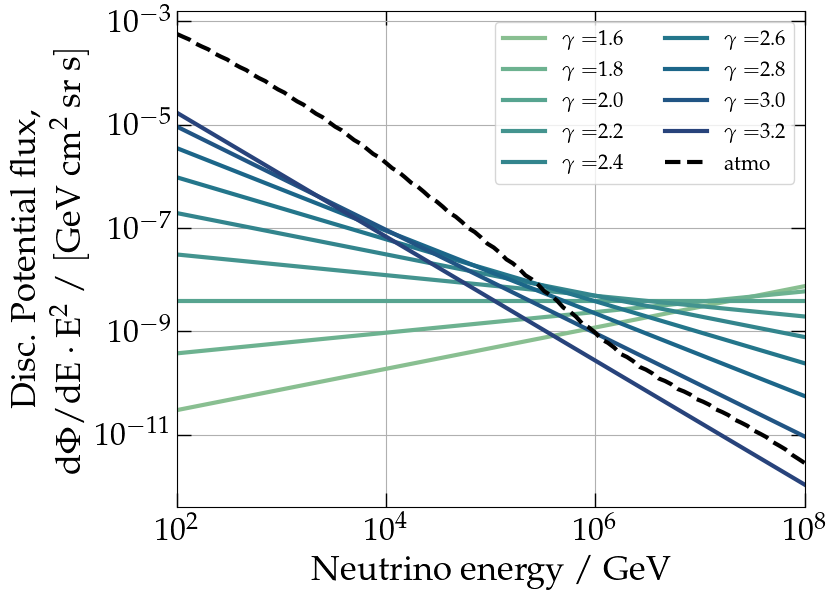

In [41]:
sns.set_palette("crest", n_colors=len(gamma_vals))


## plot the DP flux models per gamma

x_evals = np.logspace(2, 8, 100)
y_scaling = 2

plt.figure(figsize=(8, 6))

for ii, row in flux.iterrows():
    pl = power_law(x_evals, tmp_diffuse_flux.E0, row.gamma, row["Phi_0 at 100 TeV"])
    plt.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"$\gamma=${row.gamma}",
        alpha=1,
        lw=3,
    )

ss, em = np.meshgrid(sindec_mids, x_evals)
# bckg flux as a function of log10(true energy/GeV) and sin(dec)
bckg_flux_vals = np.exp(bckg_rgi((em, ss))).T  # / GeV / cm² / s / sr

plt.plot(
    x_evals,
    bckg_flux_vals.mean(axis=0) * (x_evals**y_scaling),
    label=rf"atmo",
    color="k",
    ls="--",
    alpha=1,
    lw=3,
)

plt.loglog()
plt.legend(ncol=2)
plt.ylabel(
    "Disc. Potential flux,\n" + r"${\rm d}\Phi \rm / dE \cdot E^2~ /~ [GeV~cm^2~sr~s]$"
)
plt.xlabel("Neutrino energy / GeV")
plt.xlim(1e2, 1e8)
plt.grid()